In [22]:
# The goal of this notebook is to do a preliminary study of the data we will work with, and check if it requires a further cleaning

In [24]:
# Necessary imports to read the datasets
import pandas as pd
import zipfile
import os
import numpy as np

In [26]:
# We read the dataset
df = pd.read_csv("../data/datasets/01_cleaned_daily/df_domestic.csv", low_memory=False)

In [27]:
df

,id,District,Date,Use,Number of meters,Accumulated consumption (L/day)
0,0801501001_Badalona,1,2022-01-01,Domestic,250,16242
1,0801501001_Badalona,1,2022-01-02,Domestic,251,17477
2,0801501001_Badalona,1,2022-01-03,Domestic,251,16540
3,0801501001_Badalona,1,2022-01-04,Domestic,251,17153
4,0801501001_Badalona,1,2022-01-05,Domestic,251,18619
...,...,...,...,...,...,...
1034644,0822101006_Badalona,1,2023-12-27,Domestic,9,149
1034645,0822101006_Badalona,1,2023-12-28,Domestic,9,177
1034646,0822101006_Badalona,1,2023-12-29,Domestic,9,147
1034647,0822101006_Badalona,1,2023-12-30,Domestic,9,167


In [30]:
# We group by 'id' and count the number of rows per group
ts_counts = df.groupby('id').size()

# We Filter for time series with more than 730 rows
long_series = ts_counts[ts_counts > 730]
short_series = ts_counts[ts_counts < 730]


# Number of such time series
num_long_series = len(long_series)
num_short_series = len(short_series)


print(f"Number of time series with more than 730 rows: {num_long_series}")
print(f"Number of time series with more less than 730 rows: {num_short_series}")



Number of time series with more than 730 rows: 0
Number of time series with more less than 730 rows: 4


As we can see we only have problems with 4 time series, so we can simply ignore them, as we have more than enough data to start. We could work with them trying different methods to fill missing data.

In [33]:
# 1. We ount how many unique 'id's (i.e., time series) there are
total_series = df['id'].nunique()

# 2. For each time series, we count how many unique values of 'Number of meters' it has
variable_meters = df.groupby('id')['Number of meters'].nunique()

# 3. Time series where the number of meters varies (i.e., not constant over time)
inconsistent_meters = variable_meters[variable_meters > 1]

# 4. Count and percentage
num_inconsistent = len(inconsistent_meters)
percentage_inconsistent = (num_inconsistent / total_series) * 100

# Output results
print(f"Total number of time series: {total_series}")
print(f"Number of time series with varying number of meters: {num_inconsistent}")
print(f"Percentage of inconsistent time series: {percentage_inconsistent:.2f}%")


Total number of time series: 1419
Number of time series with varying number of meters: 1417
Percentage of inconsistent time series: 99.86%


In [35]:
# We then group by 'id' and get min and max number of meters per time series
meter_stats = df.groupby('id')['Number of meters'].agg(['min', 'max'])

# Compute the increase
meter_stats['increase'] = meter_stats['max'] - meter_stats['min']

# Sort by increase descending
top_increases = meter_stats.sort_values(by='increase', ascending=False)

# Show the top 10 time series with the largest increase
print("Top 10 time series with the largest increase in number of meters:")
print(top_increases.head(10))

Top 10 time series with the largest increase in number of meters:
                      min   max  increase
id                                       
0801503013_Badalona     2   779       777
0801909033_Barcelona  564  1334       770
0801509030_Badalona   103   765       662
0801909095_Barcelona  178   797       619
0801504014_Badalona    64   679       615
0801507029_Badalona   124   729       605
0801909032_Barcelona  237   840       603
0801507002_Badalona   162   756       594
0801504001_Badalona   144   714       570
0801909030_Barcelona   26   591       565


In [37]:
# Let's check how many meters
# Ensure 'Date' is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter the two specific dates
meters_2022 = df[df['Date'] == '2022-01-01']['Number of meters'].sum()
meters_2023 = df[df['Date'] == '2023-12-31']['Number of meters'].sum()

# Compute the difference
difference = meters_2023 - meters_2022
percentage_change = (difference / meters_2022) * 100 if meters_2022 != 0 else float('nan')

# Print results
print(f"Total number of meters on 2022-01-01: {meters_2022}")
print(f"Total number of meters on 2023-12-31: {meters_2023}")
print(f"Difference: {difference} meters")
print(f"Percentage change: {percentage_change:.2f}%")

Total number of meters on 2022-01-01: 563085
Total number of meters on 2023-12-31: 812166
Difference: 249081 meters
Percentage change: 44.24%


=== Basic Stats on Meter Growth per Time Series ===
count    1419.000000
mean      175.484144
std       113.292021
min       -23.000000
25%        89.500000
50%       161.000000
75%       231.000000
max       777.000000
Name: increase, dtype: float64


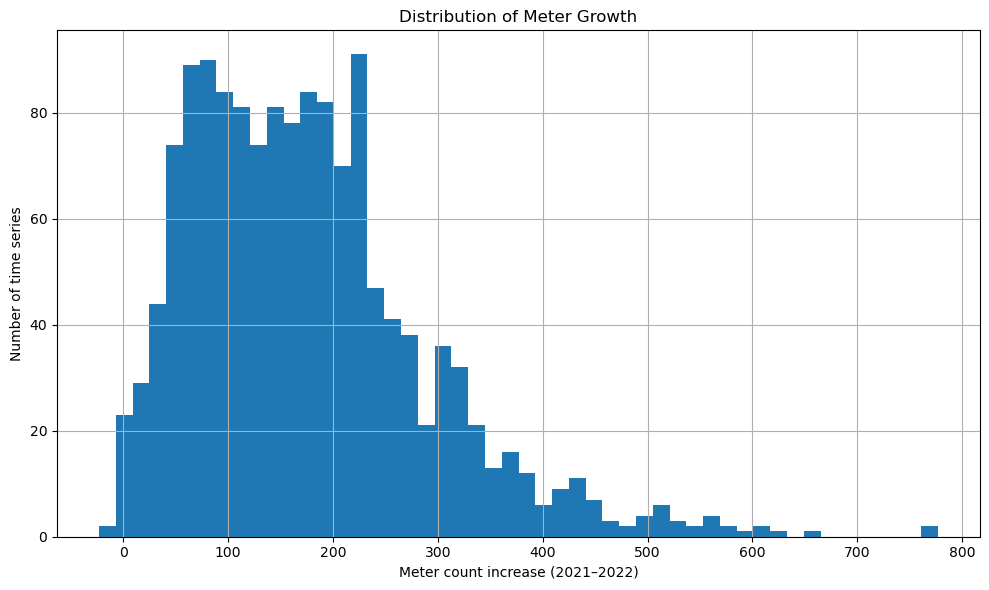

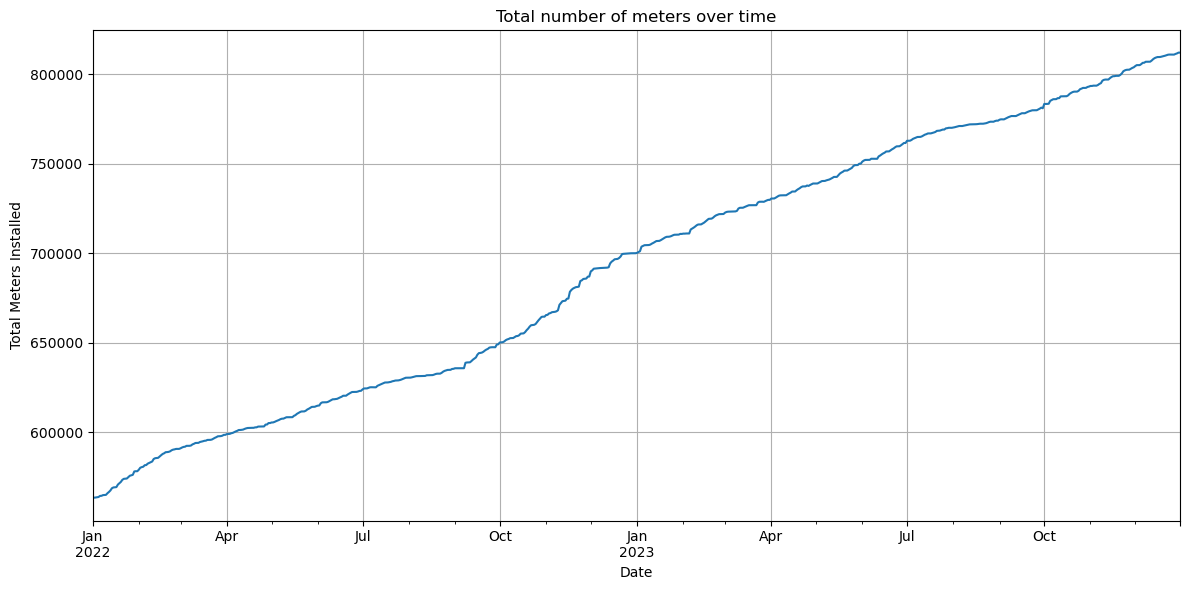


=== Top 10 Censal Sections by Meter Growth ===
                      start   end  increase
id                                         
0801503013_Badalona       2   779       777
0801909033_Barcelona    564  1334       770
0801509030_Badalona     103   765       662
0801909095_Barcelona    178   797       619
0801504014_Badalona      64   679       615
0801909032_Barcelona    237   840       603
0801507002_Badalona     162   756       594
0801507029_Badalona     124   706       582
0801504001_Badalona     144   714       570
0801909030_Barcelona     26   591       565

Number of censal sections with decreasing meters: 2


In [41]:
import matplotlib.pyplot as plt

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# We compute change in meters per censal section (id)
# Get first and last date readings per ID
first_day = df.sort_values('Date').groupby('id').first()['Number of meters']
last_day = df.sort_values('Date').groupby('id').last()['Number of meters']

# We combine into one DataFrame
meter_growth = pd.DataFrame({'start': first_day, 'end': last_day})
meter_growth['increase'] = meter_growth['end'] - meter_growth['start']

# Some basic stats on meter growth 
print("=== Basic Stats on Meter Growth per Time Series ===")
print(meter_growth['increase'].describe())

# Distribution of growth
plt.figure(figsize=(10, 6))
meter_growth['increase'].hist(bins=50)
plt.title('Distribution of Meter Growth')
plt.xlabel('Meter count increase (2021–2022)')
plt.ylabel('Number of time series')
plt.grid(True)
plt.tight_layout()
plt.savefig('meter_growth_distribution.png', dpi=300)
plt.show()

# Plot of total meters over time
daily_meters = df.groupby('Date')['Number of meters'].sum()

plt.figure(figsize=(12, 6))
daily_meters.plot()
plt.title("Total number of meters over time")
plt.xlabel("Date")
plt.ylabel("Total Meters Installed")
plt.grid(True)
plt.tight_layout()
plt.savefig('total_meter_growth.png', dpi=300)
plt.show()

# === 5. Top growing time series ===
top_growers = meter_growth.sort_values(by='increase', ascending=False).head(10)
print("\n=== Top 10 Censal Sections by Meter Growth ===")
print(top_growers)

# === 6. Optional: remove invalid or decreasing meter counts ===
negative_growth = meter_growth[meter_growth['increase'] < 0]
print(f"\nNumber of censal sections with decreasing meters: {len(negative_growth)}")


In [45]:
# We filter between 2022-01-01 and 2023-12-31
mask = (df['Date'] >= '2022-01-01') & (df['Date'] <= '2023-12-31')
filtered_df = df.loc[mask].copy()

# Group by date and sum if needed (if your data isn't already daily sums)
daily_meters = filtered_df.groupby('Date')['Number of meters'].sum()

# Get total at the start and end
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2023-12-31')

start_value = daily_meters.loc[start_date]
end_value = daily_meters.loc[end_date]

absolute_increase = end_value - start_value
percentage_increase = (absolute_increase / start_value) * 100

print(f"Total meters on 01-01-2022: {start_value}")
print(f"Total meters on 31-12-2023: {end_value}")
print(f"Absolute increase: {absolute_increase}")
print(f"Percentage increase: {percentage_increase:.2f}%")

# Print values at the requested dates
checkpoints = [
    '2022-01-01',
    '2022-07-01',
    '2023-01-01',
    '2023-07-01',
    '2023-12-31'
]

print("\nMeters at selected dates:")
for date in checkpoints:
    value = daily_meters.loc[pd.to_datetime(date)]
    print(f"{date}: {value}")

Total meters on 01-01-2022: 563085
Total meters on 31-12-2023: 812166
Absolute increase: 249081
Percentage increase: 44.24%

Meters at selected dates:
2022-01-01: 563085
2022-07-01: 623913
2023-01-01: 700236
2023-07-01: 762872
2023-12-31: 812166


In [49]:
# Get first and last 'Number of meters' per time series (id)
first_meters = df.sort_values('Date').groupby('id').first()['Number of meters']
last_meters = df.sort_values('Date').groupby('id').last()['Number of meters']

# Count number of records (days) per time series
counts = df.groupby('id').size()

# Combine into a DataFrame
meter_change = pd.DataFrame({
    'first': first_meters,
    'last': last_meters,
    'n_days': counts
})
meter_change['change'] = meter_change['last'] - meter_change['first']

# Get the 10 with the fewest meters at the end
lowest_last = meter_change.sort_values(by='last').head(10)

# We display the result
print("=== 10 Time Series with the Fewest Meters at End of Period ===")
print(lowest_last[['first', 'last', 'change', 'n_days']])

=== 10 Time Series with the Fewest Meters at End of Period ===
                       first  last  change  n_days
id                                                
0812505003_Barcelona       2     2       0     297
0807710008_Hospitalet      3     4       1     730
0822101006_Badalona        8     9       1     730
0810102034_Barcelona       6    10       4     730
0820506001_Barcelona       5    10       5     730
0810102011_Barcelona      14    15       1     430
0807302003_Hospitalet     15    15       0     730
0807710003_Hospitalet     35    38       3     730
0819403001_Barcelona      36    41       5     730
0801509004_Badalona       15    51      36     730


In [51]:
# Get first and last 'Number of meters' per time series (id)
first_meters = df.sort_values('Date').groupby('id').first()['Number of meters']
last_meters = df.sort_values('Date').groupby('id').last()['Number of meters']

# Count number of daily records per id
counts = df.groupby('id').size()

# Create a DataFrame with start, end, and change
meter_change = pd.DataFrame({
    'first': first_meters,
    'last': last_meters,
    'n_days': counts
})
meter_change['change'] = meter_change['last'] - meter_change['first']

# Sort by least increase (including negatives)
least_increase = meter_change.sort_values(by='change').head(10)

# Display the result
print("=== 10 Time Series with the Least Increase in Meters (including decreases) ===")
print(least_increase[['first', 'last', 'change', 'n_days']])


=== 10 Time Series with the Least Increase in Meters (including decreases) ===
                       first  last  change  n_days
id                                                
0810106031_Hospitalet    248   225     -23     730
0801905020_Barcelona     401   382     -19     730
0807702006_Hospitalet     67    67       0     730
0812505003_Barcelona       2     2       0     297
0807302003_Hospitalet     15    15       0     730
0822101006_Badalona        8     9       1     730
0810102011_Barcelona      14    15       1     430
0807710008_Hospitalet      3     4       1     730
0810105001_Hospitalet    356   359       3     730
0807710003_Hospitalet     35    38       3     730


In [94]:
# We will procede to start working with these 2 time series
# 0807302003_Hospitalet     15    15       0     730
# 0822101006_Badalona        8     9       1     730

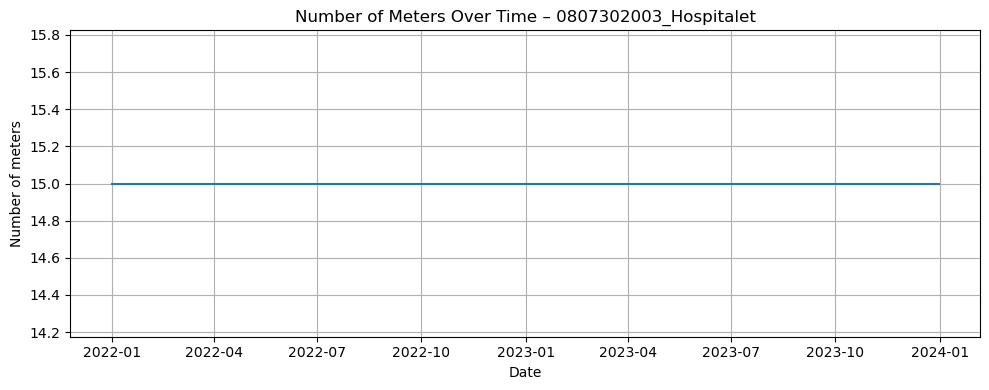

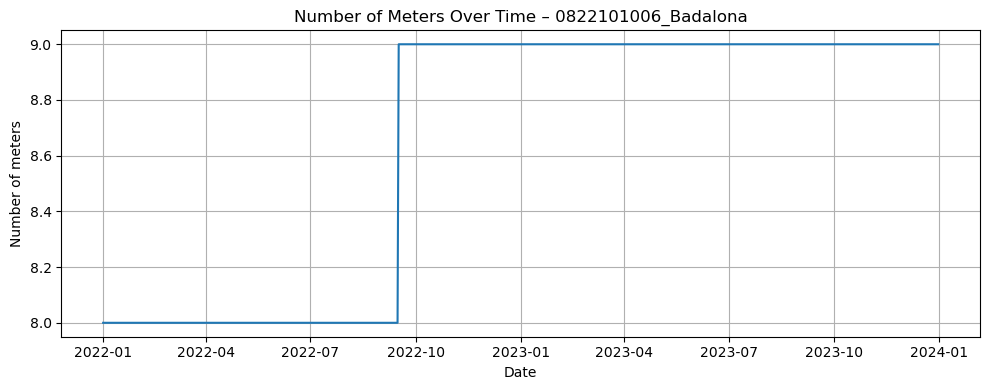

In [55]:
# Filter for the two specific IDs
ids_to_plot = ['0807302003_Hospitalet', '0822101006_Badalona']
df_subset = df[df['id'].isin(ids_to_plot)].sort_values(['id', 'Date'])

# Plot each time series meters over time
for _id in ids_to_plot:
    ts = df_subset[df_subset['id'] == _id]
    plt.figure(figsize=(10, 4))
    plt.plot(ts['Date'], ts['Number of meters'], linestyle='-')
    plt.title(f"Number of Meters Over Time – {_id}")
    plt.xlabel("Date")
    plt.ylabel("Number of meters")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

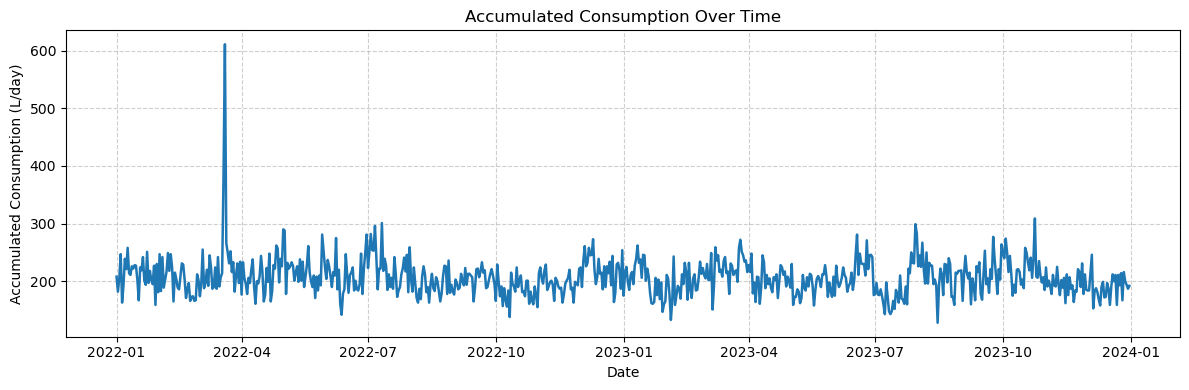

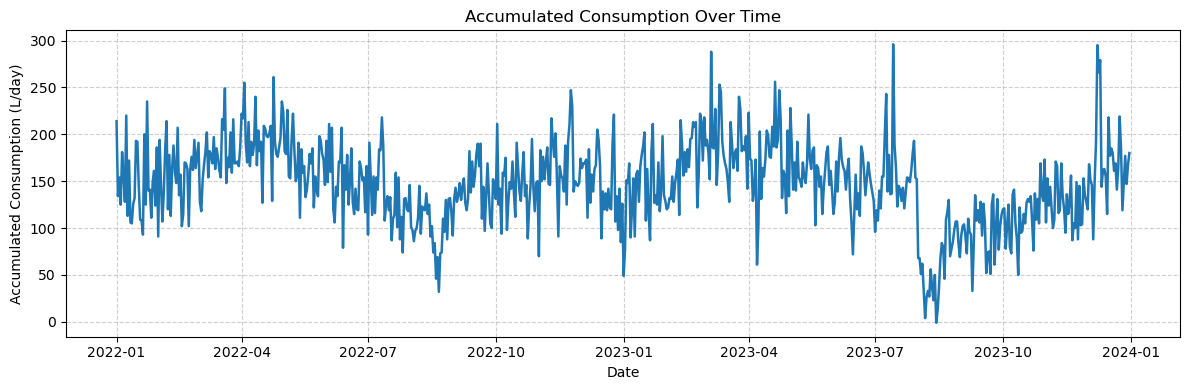

In [57]:
# Filter for the two censal sections
ids_to_plot = ['0807302003_Hospitalet', '0822101006_Badalona']
df_subset = df[df['id'].isin(ids_to_plot)].sort_values(['id', 'Date'])

# Plot the time series
for _id in ids_to_plot:
    ts = df_subset[df_subset['id'] == _id]
    plt.figure(figsize=(12, 4))
    plt.plot(ts['Date'], ts['Accumulated consumption (L/day)'], linestyle='-', linewidth=1.8)
    plt.title(f"Accumulated Consumption Over Time")
    plt.xlabel("Date")
    plt.ylabel("Accumulated Consumption (L/day)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()


In [59]:
# We ensure numeric types for relevant columns
df['Number of meters'] = pd.to_numeric(df['Number of meters'], errors='coerce')
df['Accumulated consumption (L/day)'] = pd.to_numeric(df['Accumulated consumption (L/day)'], errors='coerce')

# We identify IDs that have at least one negative value
negative_mask = (df['Number of meters'] < 0) | (df['Accumulated consumption (L/day)'] < 0)
ids_with_negatives = df.loc[negative_mask, 'id'].unique()

# We remove all rows belonging to those IDs
df_clean = df[~df['id'].isin(ids_with_negatives)].copy()

# Cleaned series
print(f"{len(ids_with_negatives)} time series (IDs) removed due to negative values.")
print(f"{df_clean['id'].nunique()} time series remaining.")

129 time series (IDs) removed due to negative values.
1290 time series remaining.


In [61]:
# We add the normalization
df_clean['Consumption per meter'] = (df_clean['Accumulated consumption (L/day)'] / df_clean['Number of meters']).round(2)

In [63]:
df_clean

,id,District,Date,Use,Number of meters,Accumulated consumption (L/day),Consumption per meter
0,0801501001_Badalona,1,2022-01-01,Domestic,250,16242,64.97
1,0801501001_Badalona,1,2022-01-02,Domestic,251,17477,69.63
2,0801501001_Badalona,1,2022-01-03,Domestic,251,16540,65.90
3,0801501001_Badalona,1,2022-01-04,Domestic,251,17153,68.34
4,0801501001_Badalona,1,2022-01-05,Domestic,251,18619,74.18
...,...,...,...,...,...,...,...
1033914,0820506001_Barcelona,6,2023-12-27,Domestic,10,1252,125.20
1033915,0820506001_Barcelona,6,2023-12-28,Domestic,10,1003,100.30
1033916,0820506001_Barcelona,6,2023-12-29,Domestic,10,1336,133.60
1033917,0820506001_Barcelona,6,2023-12-30,Domestic,10,742,74.20


In [73]:
# Let's delete time series which are not complete
# Check how many rows each meter has
lengths = df_clean.groupby("id").size()
print("Total meters:", len(lengths))
print("Meters with exactly 730 rows:", (lengths == 730).sum())
print("Meters with < 730 rows:", (lengths < 730).sum())
print("Meters with > 730 rows:", (lengths > 730).sum())

incomplete_ids = lengths[lengths != 730]
print("\nIDs of not complete meters:")
print(incomplete_ids)

# We keep only meters with exactly 730 rows
valid_ids = lengths[lengths == 730].index

# We filter the df to only those IDs
df_clean = df_clean[df_clean["id"].isin(valid_ids)].copy()

Total meters: 1286
Meters with exactly 730 rows: 1286
Meters with < 730 rows: 0
Meters with > 730 rows: 0

IDs of not complete meters:
Series([], dtype: int64)


In [75]:
# Let's store the domestic df cleaned
# tenir en compte que he sobreescrit
df_clean.to_csv("../data/datasets/01_cleaned_daily/df_domestic_cleaned.csv", index=False)